In [2]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# Download NLTK resources (uncomment if needed)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/pedro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/pedro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Step 2: Load and examine the data
# Load the CSV file
file_path = './incorrectly_answered_questions_consolidated.csv'
df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values in each column:")
display(df.isnull().sum())

# Basic statistics for numeric columns
print("\nBasic statistics:")
display(df.describe())

# Count values in categorical columns
print("\nDataset distribution:")
print(f"Number of unique questions: {df['question'].nunique()}")
print(f"Dataset sources: {df['dataset'].unique()}")
print(f"Dataset distribution: {df['dataset'].value_counts()}")

Dataset shape: (2161, 13)

First few rows:


dataset         id  \
0  mmlu_clinical_knowledge  index_102   
1  mmlu_clinical_knowledge  index_106   
2  mmlu_clinical_knowledge  index_107   
3  mmlu_clinical_knowledge  index_108   
4  mmlu_clinical_knowledge  index_111   

                                            question ground_truth_answer  \
0  A 67-year-old man, three hours post-transureth...                   B   
1  The sex of a child is dictated by the inherita...                   D   
2  Which of the following is true in spastic para...                   A   
3  The synthesis of glucose from lactate, glycero...                   D   
4  How many different types of microorganisms may...                   C   

  ground_truth_explanation  num_models_incorrect  \
0                      NaN                     1   
1                      NaN                     1   
2                      NaN                     1   
3                      NaN                     1   
4                      NaN                     3   

          models_incorrect_list          gemini_model_id  \
0                  vertex_gemma  models/gemini-2.0-flash   
1                  vertex_gemma  models/gemini-2.0-flash   
2                  vertex_gemma  models/gemini-2.0-flash   
3                  vertex_gemma  models/gemini-2.0-flash   
4  gemini, nvidia, vertex_gemma  models/gemini-2.0-flash   

           nvidia_model_id       vertex_gemma_model_id gemini_parsed  \
0  deepseek-ai/deepseek-r1  vertex-7050478675136872448             B   
1  deepseek-ai/deepseek-r1  vertex-7050478675136872448             D   
2  deepseek-ai/deepseek-r1  vertex-7050478675136872448             A   
3  deepseek-ai/deepseek-r1  vertex-7050478675136872448             D   
4  deepseek-ai/deepseek-r1  vertex-7050478675136872448             D   

  nvidia_parsed vertex_gemma_parsed  
0             B                   A  
1             D                   A  
2             A                   C  
3             D                   A  
4             D                   A


Missing values in each column:


dataset                        0
id                             0
question                       0
ground_truth_answer            0
ground_truth_explanation    1637
num_models_incorrect           0
models_incorrect_list          0
gemini_model_id              611
nvidia_model_id              611
vertex_gemma_model_id          1
gemini_parsed                615
nvidia_parsed                807
vertex_gemma_parsed           35
dtype: int64


Basic statistics:


num_models_incorrect
count           2161.000000
mean               1.426654
std                0.687395
min                1.000000
25%                1.000000
50%                1.000000
75%                2.000000
max                3.000000


Dataset distribution:
Number of unique questions: 2161
Dataset sources: ['mmlu_clinical_knowledge' 'pubmedqa_pqa_l' 'medmcqa' 'medxpertqa']
Dataset distribution: dataset
medxpertqa                 843
pubmedqa_pqa_l             608
medmcqa                    590
mmlu_clinical_knowledge    120
Name: count, dtype: int64


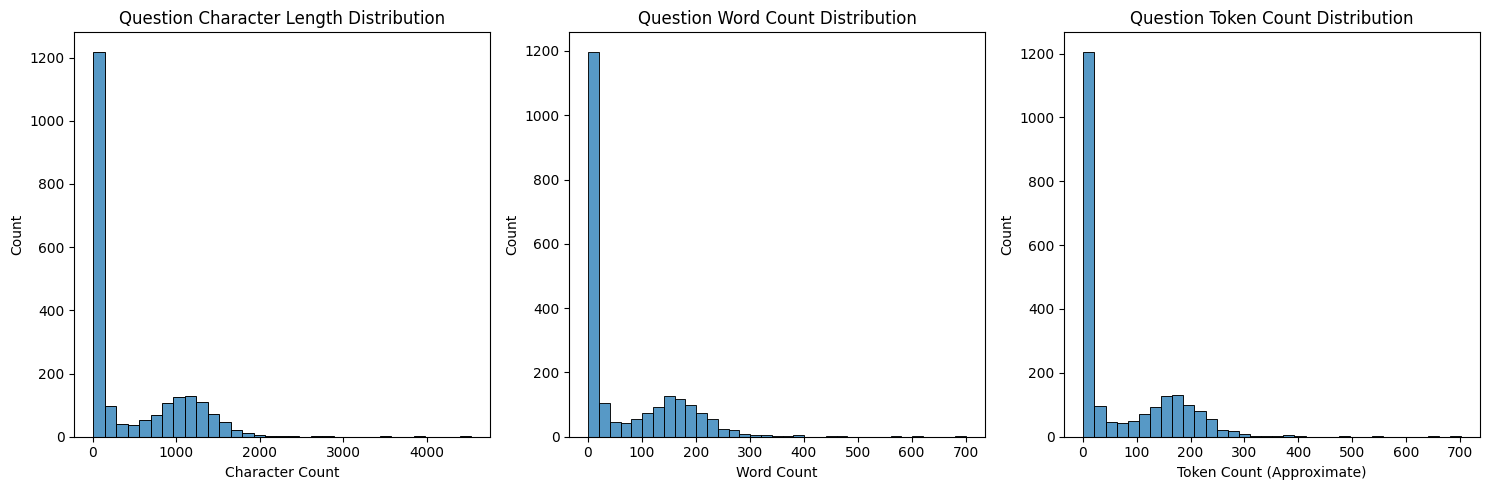

Question length statistics:


question_length   word_count  token_count
count      2161.000000  2161.000000  2161.000000
mean        480.967608    71.907450    73.689496
std         565.188777    85.770747    87.094453
min           9.000000     1.000000     1.000000
25%          66.000000    10.000000    10.000000
50%         115.000000    16.000000    17.000000
75%         964.000000   141.000000   147.000000
max        4527.000000   701.000000   702.000000

In [4]:
# Step 3: Question length analysis (simplified version)
import string

# Add columns for question length using simpler methods
df['question_length'] = df['question'].apply(lambda x: len(str(x)))
df['word_count'] = df['question'].apply(lambda x: len(str(x).split()))

# Simple token counter that doesn't require NLTK
def simple_token_count(text):
    text = str(text)
    # Replace punctuation with spaces
    for char in string.punctuation:
        text = text.replace(char, ' ')
    # Split by whitespace and count non-empty tokens
    return len([token for token in text.split() if token])

df['token_count'] = df['question'].apply(simple_token_count)

# Visualize question length distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['question_length'])
plt.title('Question Character Length Distribution')
plt.xlabel('Character Count')

plt.subplot(1, 3, 2)
sns.histplot(df['word_count'])
plt.title('Question Word Count Distribution')
plt.xlabel('Word Count')

plt.subplot(1, 3, 3)
sns.histplot(df['token_count'])
plt.title('Question Token Count Distribution')
plt.xlabel('Token Count (Approximate)')

plt.tight_layout()
plt.show()

# Summary statistics for question length
print("Question length statistics:")
length_stats = df[['question_length', 'word_count', 'token_count']].describe()
display(length_stats)

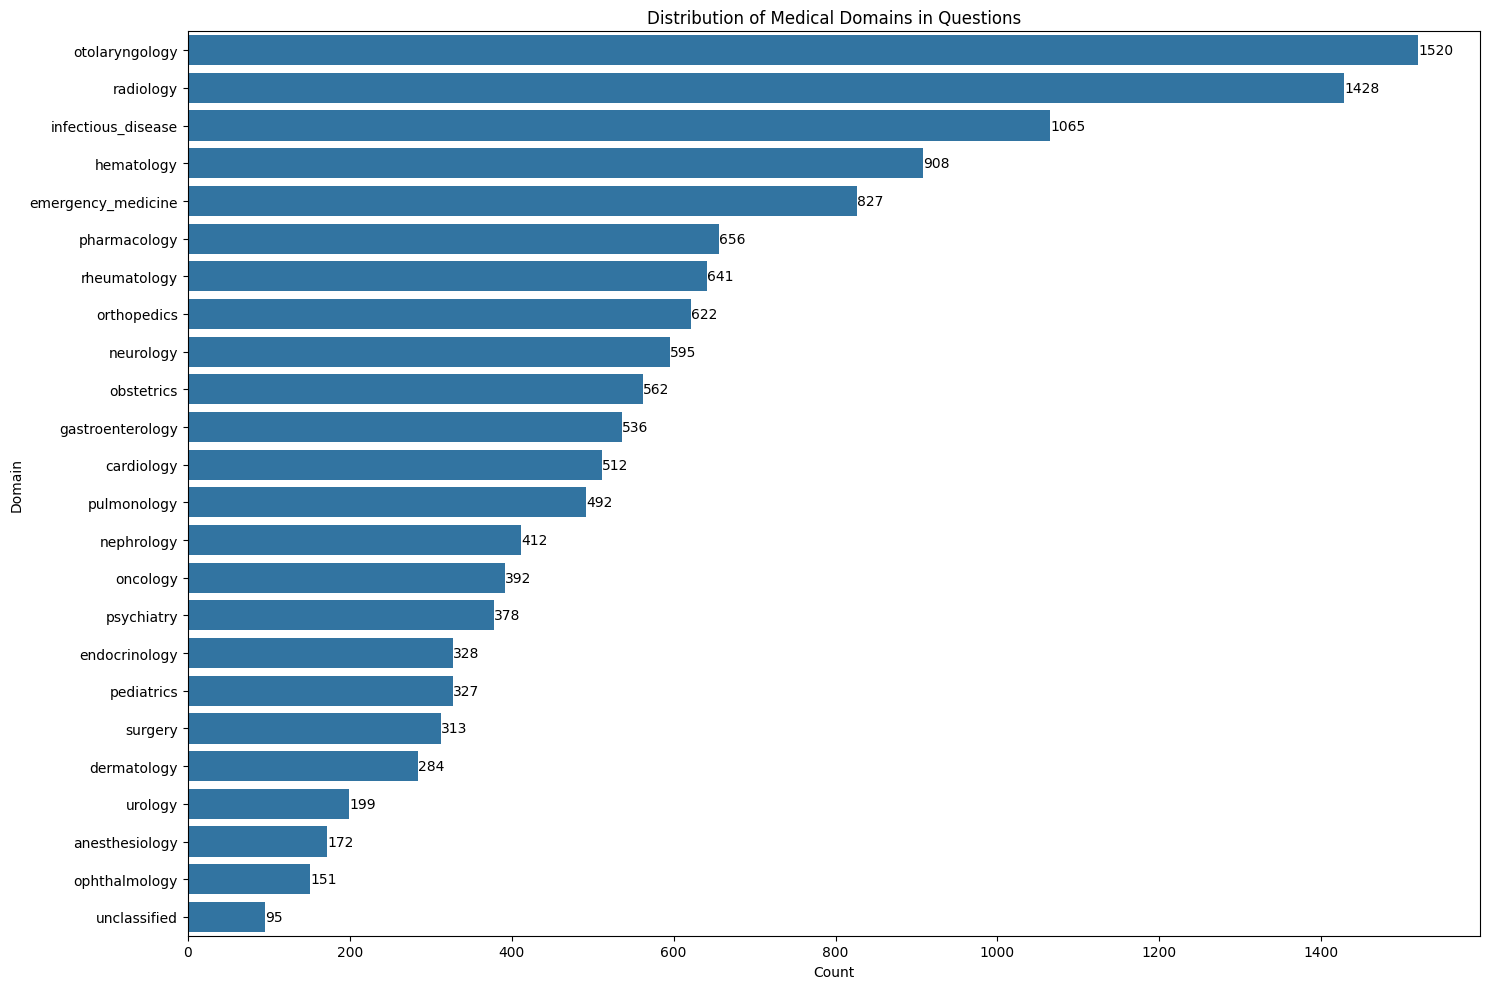

Total questions: 2161
Questions with at least one domain: 2066
Unclassified questions: 95
Percentage classified: 95.60%

Most common domain combinations:
unclassified: 95
otolaryngology: 39
radiology: 31
otolaryngology, radiology: 22
infectious_disease: 21
pharmacology: 12
infectious_disease, radiology: 11
orthopedics, otolaryngology: 10
hematology: 10
infectious_disease, otolaryngology: 10


In [5]:
# Step 4: Enhanced Domain Categorization
# Significantly expanded medical domains and keywords
medical_domains = {
    'cardiology': [
        'heart', 'cardiac', 'myocardial', 'coronary', 'ecg', 'echocardiogram', 'echocardiography',
        'arrhythmia', 'hypertension', 'angina', 'palpitation', 'tachycardia', 'bradycardia', 
        'aorta', 'atrial', 'ventricular', 'fibrillation', 'valve', 'mitral', 'aortic', 'cardiovascular',
        'infarct', 'infarction', 'chest pain', 'stent', 'angiogram', 'catheter', 'pacemaker', 'defibrillator',
        'lipid', 'cholesterol', 'thrombosis', 'embolism', 'murmur', 'cardiomyopathy', 'statin'
    ],
    'neurology': [
        'brain', 'neural', 'neuron', 'seizure', 'stroke', 'cns', 'spinal', 'meningitis',
        'headache', 'migraine', 'parkinson', 'alzheimer', 'dementia', 'neuropathy', 'multiple sclerosis',
        'epilepsy', 'mri', 'eeg', 'cerebellar', 'cerebellum', 'cerebral', 'cerebrospinal', 'csf',
        'encephalitis', 'encephalopathy', 'neuralgia', 'palsy', 'tremor', 'vertigo', 'syncope',
        'guillain-barre', 'myasthenia', 'gravis', 'cranial nerve', 'tia', 'hemorrhage', 'aneurysm'
    ],
    'orthopedics': [
        'bone', 'joint', 'fracture', 'spine', 'knee', 'shoulder', 'hip', 'arthritis', 'osteo',
        'orthopedic', 'tendon', 'ligament', 'cartilage', 'meniscus', 'rotator cuff', 'dislocation',
        'sprain', 'strain', 'gout', 'rheumatoid', 'bursitis', 'osteoporosis', 'scoliosis', 'kyphosis',
        'lordosis', 'disc', 'disk', 'vertebra', 'vertebral', 'femur', 'tibia', 'fibula', 'humerus',
        'radius', 'ulna', 'pelvis', 'cervical', 'lumbar', 'thoracic', 'sacral', 'acl', 'mcl', 'pcl',
        'glenoid', 'acromioclavicular', 'arthroplasty', 'osteomyelitis', 'prosthesis'
    ],
    'gastroenterology': [
        'stomach', 'intestine', 'liver', 'pancreas', 'colon', 'hepatic', 'ulcer', 'gallbladder',
        'esophagus', 'esophageal', 'reflux', 'gerd', 'abdomen', 'abdominal', 'bowel', 'ibs', 'crohn',
        'colitis', 'cirrhosis', 'hepatitis', 'jaundice', 'biliary', 'cholecystitis', 'pancreatitis',
        'dysphagia', 'gastritis', 'constipation', 'diarrhea', 'melena', 'gastric', 'duodenal', 'jejunum',
        'ileum', 'appendicitis', 'appendix', 'rectum', 'rectal', 'anal', 'anus', 'hemorrhoid',
        'diverticulitis', 'diverticulosis', 'endoscopy', 'colonoscopy', 'gastroscopy'
    ],
    'pulmonology': [
        'lung', 'respiratory', 'breathing', 'asthma', 'copd', 'pneumonia', 'pulmonary',
        'bronchitis', 'bronchial', 'pleura', 'pleural', 'chest', 'dyspnea', 'cough', 'tuberculosis',
        'emphysema', 'oxygen', 'hypoxia', 'ventilation', 'ventilator', 'intubation', 'tachypnea',
        'spirometry', 'sarcoidosis', 'hemoptysis', 'apnea', 'embolism', 'fibrosis', 'alveoli',
        'alveolar', 'bronchodilator', 'hyperventilation', 'pneumothorax', 'thoracentesis'
    ],
    'dermatology': [
        'skin', 'rash', 'dermatitis', 'eczema', 'psoriasis', 'melanoma', 'acne', 'pruritus',
        'urticaria', 'hives', 'lesion', 'blister', 'nodule', 'dermatologic', 'cutaneous', 'epidermis',
        'dermis', 'cellulitis', 'folliculitis', 'wart', 'herpes', 'papule', 'pustule', 'vitiligo',
        'alopecia', 'keratosis', 'carcinoma', 'basal cell', 'squamous cell', 'melanocytic', 'nevus',
        'seborrheic', 'impetigo', 'pemphigus', 'lupus'
    ],
    'endocrinology': [
        'hormone', 'thyroid', 'diabetes', 'insulin', 'adrenal', 'pituitary', 'glucose', 'endocrine',
        'hyperglycemia', 'hypoglycemia', 'diabetic', 'hba1c', 'hemoglobin a1c', 'parathyroid',
        'testosterone', 'estrogen', 'progesterone', 'cortisol', 'cushing', 'addison', 'hyperthyroidism',
        'hypothyroidism', 'thyroiditis', 'goiter', 'graves', 'hashimoto', 'acromegaly', 'gigantism',
        'dwarfism', 'hypopituitarism', 'hyperpituitarism', 'tsh', 't3', 't4', 'amenorrhea', 'hirsutism',
        'polycystic ovary', 'pcos', 'metabolic syndrome', 'aldosterone', 'hyperaldosteronism',
        'hypoaldosteronism', 'ketoacidosis', 'glycemic', 'prolactin', 'prolactinoma', 'carbohydrate'
    ],
    'nephrology': [
        'kidney', 'renal', 'dialysis', 'glomerular', 'nephritis', 'nephrotic', 'proteinuria',
        'hematuria', 'creatinine', 'bun', 'urea', 'ckd', 'chronic kidney disease', 'acute kidney injury',
        'aki', 'glomerulonephritis', 'pyelonephritis', 'hydronephrosis', 'urinary', 'urine', 'bladder',
        'cystitis', 'ureter', 'urethra', 'electrolyte', 'potassium', 'sodium', 'hyponatremia',
        'hypernatremia', 'hypokalemia', 'hyperkalemia', 'acidosis', 'alkalosis', 'diuretic',
        'nephrolithiasis', 'urolithiasis', 'stone', 'polycystic', 'uremia', 'azotemia', 'oliguria',
        'anuria', 'polyuria', 'dysuria', 'nocturia', 'cystoscopy', 'pyelogram'
    ],
    'obstetrics': [
        'pregnancy', 'birth', 'cesarean', 'uterus', 'fetus', 'postpartum', 'gravid', 'gestation',
        'prenatal', 'antenatal', 'perinatal', 'trimester', 'preeclampsia', 'eclampsia', 'labor',
        'delivery', 'placenta', 'placental', 'amniotic', 'amniocentesis', 'cervix', 'cervical',
        'dilate', 'dilation', 'contraction', 'gestational', 'obstetric', 'ectopic', 'miscarriage',
        'abortion', 'stillbirth', 'umbilical', 'maternal', 'para', 'gravida', 'rupture of membranes',
        'ultrasound', 'sonogram', 'pelvic', 'episiotomy', 'oxytocin', 'pitocin', 'epidural'
    ],
    'pediatrics': [
        'child', 'infant', 'newborn', 'pediatric', 'congenital', 'baby', 'neonatal', 'neonate',
        'toddler', 'adolescent', 'developmental', 'milestones', 'vaccination', 'immunization',
        'failure to thrive', 'growth', 'jaundice', 'colic', 'teething', 'adhd', 'autism', 'asperger',
        'respiratory syncytial virus', 'rsv', 'rotavirus', 'croup', 'otitis media', 'ear infection',
        'meningococcal', 'pertussis', 'whooping cough', 'sids', 'diaper', 'breast feeding', 'formula',
        'mumps', 'measles', 'rubella', 'varicella', 'chickenpox', 'kawasaki'
    ],
    'infectious_disease': [
        'infection', 'bacteria', 'virus', 'antibiotic', 'sepsis', 'hiv', 'pneumonia', 'fungal',
        'parasite', 'parasitic', 'microbial', 'antimicrobial', 'antibiotic', 'antiviral', 'antifungal',
        'antiparasitic', 'susceptibility', 'resistance', 'mrsa', 'vre', 'esbl', 'cre', 'tuberculosis',
        'malaria', 'dengue', 'ebola', 'zika', 'lyme', 'meningitis', 'encephalitis', 'cellulitis',
        'abscess', 'osteomyelitis', 'endocarditis', 'septic', 'hepatitis', 'hiv', 'aids', 'influenza',
        'flu', 'immunodeficiency', 'vaccination', 'immunization', 'std', 'sti', 'syphilis', 'gonorrhea',
        'chlamydia', 'herpes', 'hpv', 'fever', 'neutropenia', 'leukopenia'
    ],
    'hematology': [
        'blood', 'anemia', 'leukemia', 'lymphoma', 'platelet', 'coagulation', 'thrombosis', 'clot',
        'bleeding', 'hemoglobin', 'hematocrit', 'transfusion', 'hemophilia', 'sickle cell', 'thalassemia',
        'wbc', 'rbc', 'neutrophil', 'lymphocyte', 'monocyte', 'eosinophil', 'basophil', 'von willebrand',
        'hemolytic', 'purpura', 'thrombocytopenia', 'polycythemia', 'myeloma', 'hodgkin', 'non-hodgkin',
        'spleen', 'splenic', 'pernicious', 'macrocytic', 'microcytic', 'normocytic', 'iron deficiency',
        'ferritin', 'b12', 'folate', 'disseminated intravascular', 'dic', 'anticoagulant', 'heparin', 'warfarin'
    ],
    'oncology': [
        'cancer', 'tumor', 'carcinoma', 'sarcoma', 'lymphoma', 'leukemia', 'metastasis', 'metastatic',
        'neoplasm', 'neoplastic', 'malignant', 'benign', 'biopsy', 'chemotherapy', 'radiation therapy',
        'radiotherapy', 'oncology', 'oncologic', 'mastectomy', 'lumpectomy', 'prostatectomy', 'orchiectomy',
        'hysterectomy', 'oophorectomy', 'mammogram', 'colonoscopy', 'pap smear', 'psa', 'staging',
        'grade', 'differentiation', 'remission', 'palliative', 'hospice', 'myeloma', 'glioma', 'glioblastoma',
        'melanoma', 'carcinoembryonic', 'cea', 'brca', 'lynch syndrome', 'adenoma', 'adenocarcinoma'
    ],
    'ophthalmology': [
        'eye', 'vision', 'ocular', 'ophthalmology', 'retina', 'retinal', 'cornea', 'corneal', 'cataract',
        'glaucoma', 'myopia', 'hyperopia', 'astigmatism', 'presbyopia', 'strabismus', 'amblyopia',
        'macular degeneration', 'diabetic retinopathy', 'conjunctivitis', 'keratitis', 'uveitis',
        'iritis', 'pupil', 'iris', 'sclera', 'lens', 'vitreous', 'optic nerve', 'blindness', 'visual',
        'intraocular', 'tonometry', 'ophthalmoscopy', 'fundoscopy', 'dry eye', 'blepharitis',
        'ptosis', 'floaters', 'photophobia', 'diplopia', 'scotoma', 'visual field'
    ],
    'otolaryngology': [
        'ear', 'nose', 'throat', 'ent', 'otolaryngology', 'hearing', 'deaf', 'tinnitus', 'vertigo',
        'otitis', 'rhinitis', 'sinusitis', 'pharyngitis', 'laryngitis', 'tonsillitis', 'adenoid',
        'tympanic', 'eardrum', 'mastoid', 'mastoiditis', 'vestibular', 'meniere', 'acoustic neuroma',
        'epistaxis', 'nasal', 'sinus', 'deviated septum', 'polyp', 'rhinorrhea', 'dysphonia',
        'hoarseness', 'laryngeal', 'pharyngeal', 'dysphagia', 'tracheostomy', 'otorrhea',
        'otalgia', 'audiometry', 'cochlear', 'tympanometry'
    ],
    'psychiatry': [
        'mental', 'psychiatric', 'psychology', 'depression', 'anxiety', 'bipolar', 'schizophrenia',
        'psychosis', 'psychotic', 'delirium', 'dementia', 'alzheimer', 'adhd', 'add', 'autism',
        'asperger', 'ocd', 'obsessive-compulsive', 'ptsd', 'post-traumatic', 'panic', 'phobia',
        'anorexia', 'bulimia', 'eating disorder', 'insomnia', 'suicide', 'suicidal', 'homicidal',
        'personality disorder', 'borderline', 'narcissistic', 'antisocial', 'histrionic', 'mood',
        'serotonin', 'dopamine', 'antidepressant', 'antipsychotic', 'benzodiazepine', 'lithium',
        'electroconvulsive', 'psychotherapy', 'cognitive behavioral', 'cbt'
    ],
    'urology': [
        'urinary', 'bladder', 'prostate', 'ureter', 'urethra', 'penis', 'testicle', 'testis',
        'scrotum', 'erectile', 'ejaculation', 'urological', 'urologic', 'cystitis', 'pyelonephritis',
        'prostatitis', 'benign prostatic hyperplasia', 'bph', 'hematuria', 'proteinuria', 'incontinence',
        'urinary retention', 'enuresis', 'nocturia', 'polyuria', 'oliguria', 'hydrocele', 'varicocele',
        'epididymitis', 'orchitis', 'vasectomy', 'circumcision', 'phimosis', 'paraphimosis',
        'hypospadias', 'epispadias', 'pyuria', 'dysuria', 'cystoscopy', 'urodynamic'
    ],
    'rheumatology': [
        'rheumatoid', 'arthritis', 'lupus', 'gout', 'fibromyalgia', 'autoimmune', 'rheumatic',
        'rheumatology', 'ankylosing spondylitis', 'sjogren', 'scleroderma', 'dermatomyositis',
        'polymyositis', 'vasculitis', 'polyarteritis', 'polymyalgia', 'temporal arteritis',
        'giant cell arteritis', 'wegener', 'granulomatosis', 'polyarteritis nodosa', 'reiter',
        'psoriatic arthritis', 'enteropathic arthritis', 'reactive arthritis', 'diffuse',
        'connective tissue', 'antinuclear', 'ana', 'rheumatoid factor', 'rf', 'anticitrullinated',
        'anti-ccp', 'erythrocyte sedimentation rate', 'esr', 'c-reactive protein', 'crp'
    ],
    'emergency_medicine': [
        'emergency', 'trauma', 'accident', 'injury', 'fracture', 'hemorrhage', 'bleeding',
        'shock', 'resuscitation', 'cpr', 'cardiac arrest', 'respiratory arrest', 'airway',
        'intubation', 'defibrillation', 'poison', 'toxicity', 'overdose', 'burn', 'wound',
        'laceration', 'abrasion', 'contusion', 'avulsion', 'amputation', 'dislocation',
        'triage', 'ambulance', 'paramedic', 'ems', 'als', 'bls', 'acls', 'pals', 'crash',
        'unconscious', 'unresponsive', 'glasgow', 'abcde', 'primary survey', 'secondary survey'
    ],
    'pharmacology': [
        'drug', 'medication', 'pharmacology', 'pharmacological', 'pharmacokinetic', 'pharmacodynamic',
        'dose', 'dosage', 'therapeutic', 'toxicity', 'overdose', 'adverse effect', 'side effect',
        'contraindication', 'interaction', 'bioavailability', 'half-life', 'clearance', 'absorption',
        'distribution', 'metabolism', 'excretion', 'induction', 'inhibition', 'receptor', 'agonist',
        'antagonist', 'partial agonist', 'inverse agonist', 'oral', 'intravenous', 'intramuscular',
        'subcutaneous', 'topical', 'buccal', 'sublingual', 'rectal', 'inhalation'
    ],
    'anesthesiology': [
        'anesthesia', 'anesthetic', 'anesthesiology', 'sedation', 'general anesthesia', 'local anesthesia',
        'regional anesthesia', 'spinal anesthesia', 'epidural', 'nerve block', 'conscious sedation',
        'propofol', 'ketamine', 'etomidate', 'benzodiazepine', 'barbiturate', 'opioid', 'fentanyl',
        'remifentanil', 'morphine', 'neuromuscular blocker', 'succinylcholine', 'rocuronium',
        'vecuronium', 'intubation', 'laryngoscopy', 'mask ventilation', 'airway', 'capnography',
        'pulse oximetry', 'bispectral index', 'bis', 'mac', 'minimum alveolar concentration'
    ],
    'surgery': [
        'surgery', 'surgical', 'operation', 'operative', 'surgeon', 'incision', 'excision', 'resection',
        'anastomosis', 'ligation', 'suture', 'staple', 'laparoscopy', 'laparoscopic', 'laparotomy',
        'thoracotomy', 'thoracoscopy', 'craniectomy', 'craniotomy', 'laminectomy', 'discectomy',
        'hysterectomy', 'oophorectomy', 'salpingectomy', 'cholecystectomy', 'appendectomy',
        'colectomy', 'gastrectomy', 'splenectomy', 'nephrectomy', 'prostatectomy', 'mastectomy',
        'thyroidectomy', 'herniorrhaphy', 'hemorrhoidectomy', 'transplant', 'graft'
    ],
    'radiology': [
        'radiology', 'imaging', 'x-ray', 'radiograph', 'ultrasound', 'sonography', 'computed tomography',
        'ct scan', 'magnetic resonance', 'mri', 'angiography', 'angiogram', 'fluoroscopy', 'contrast',
        'radioopaque', 'radiolucent', 'radiodense', 'hyperechoic', 'hypoechoic', 'isoechoic',
        'hyperintense', 'hypointense', 'isointense', 'density', 'artifact', 'resolution',
        'radiopaque', 'positron emission', 'pet', 'spect', 'nuclear medicine', 'mammography',
        'interventional', 'barium', 'gadolinium', 'iodinated'
    ]
}

# Function to categorize a question using multiple approaches
def enhanced_categorize_question(row):
    # Get all text fields that might contain domain clues
    question = str(row['question']).lower()
    
    # If available, also check the explanation
    explanation = ""
    if 'ground_truth_explanation' in row and not pd.isna(row['ground_truth_explanation']):
        explanation = str(row['ground_truth_explanation']).lower()
    
    combined_text = question + " " + explanation
    
    # First approach: Simple keyword matching
    categories = []
    for domain, keywords in medical_domains.items():
        for keyword in keywords:
            if keyword.lower() in combined_text:
                categories.append(domain)
                break
    
    # Second approach: Check for specific answer choices that might indicate domain
    answer_choices = re.findall(r'\([A-Z]\)\s*([^()]+?)(?=\s*\([A-Z]\)|\s*$)', question)
    if not answer_choices:
        # Try another pattern that might capture answer choices
        answer_choices = re.findall(r'(?:^|\n)\s*([A-Z])\)\s*([^()\n]+)', question)
    
    # Check answer choices for domain keywords
    if answer_choices:
        for choice in answer_choices:
            choice_text = str(choice).lower()
            for domain, keywords in medical_domains.items():
                for keyword in keywords:
                    if keyword.lower() in choice_text and domain not in categories:
                        categories.append(domain)
    
    # Third approach: Look for specific medical conditions or procedures
    # (This is a simplification - in a real implementation you might use NER or a medical ontology)
    medical_conditions = [
        ('diabetes', 'endocrinology'),
        ('hypertension', 'cardiology'),
        ('asthma', 'pulmonology'),
        ('fracture', 'orthopedics'),
        ('pregnancy', 'obstetrics'),
        ('newborn', 'pediatrics'),
        ('infection', 'infectious_disease'),
        ('thyroid', 'endocrinology'),
        ('arthritis', 'rheumatology'),
        ('seizure', 'neurology'),
        ('cancer', 'oncology'),
        ('leukemia', 'hematology'),
        ('glaucoma', 'ophthalmology'),
        ('kidney', 'nephrology'),
        ('liver', 'gastroenterology'),
        ('gallbladder', 'gastroenterology'),
        ('surgery', 'surgery'),
        ('anesthesia', 'anesthesiology'),
        ('cardiac', 'cardiology'),
        ('drug', 'pharmacology'),
        ('emergency', 'emergency_medicine'),
        ('trauma', 'emergency_medicine'),
        ('x-ray', 'radiology'),
        ('ct', 'radiology'),
        ('mri', 'radiology')
    ]
    
    for condition, domain in medical_conditions:
        if condition in combined_text and domain not in categories:
            categories.append(domain)
    
    # Use TF-IDF based approach if still unclassified
    if not categories and 'clean_question' in row and not pd.isna(row['clean_question']):
        clean_text = str(row['clean_question']).lower()
        # This would require pre-trained TF-IDF vectors for each domain
        # For now, we'll use a simpler approach with domain-specific term frequencies
        
        # Count domain-specific terms
        domain_scores = {}
        for domain, keywords in medical_domains.items():
            score = sum(1 for keyword in keywords if keyword in clean_text)
            if score > 0:
                domain_scores[domain] = score
        
        # Get top scoring domains
        if domain_scores:
            max_score = max(domain_scores.values())
            categories = [domain for domain, score in domain_scores.items() if score == max_score]
    
    # Returns categories or 'unclassified'
    return categories if categories else ['unclassified']

# Process text for better matching
def preprocess_text(text):
    return re.sub(r'\s+', ' ', str(text).lower().strip())

# Apply enhanced categorization to each question
df['clean_question'] = df['question'].apply(preprocess_text)
if 'ground_truth_explanation' in df.columns:
    df['clean_explanation'] = df['ground_truth_explanation'].apply(preprocess_text)

# Apply the enhanced categorization
df['domains'] = df.apply(enhanced_categorize_question, axis=1)

# Expand the domains list to count frequency
all_domains = []
for domains in df['domains']:
    all_domains.extend(domains)

# Count domain occurrences
domain_counts = Counter(all_domains)

# Visualize domain distribution
plt.figure(figsize=(15, 10))
domain_df = pd.DataFrame.from_dict(domain_counts, orient='index').reset_index()
domain_df.columns = ['Domain', 'Count']
domain_df = domain_df.sort_values('Count', ascending=False)

# Plot results
ax = sns.barplot(x='Count', y='Domain', data=domain_df)
plt.title('Distribution of Medical Domains in Questions')
plt.tight_layout()

# Add count values to the bars
for i, v in enumerate(domain_df['Count']):
    ax.text(v + 0.1, i, str(v), va='center')

plt.show()

# Print statistics on categorization
print(f"Total questions: {len(df)}")
print(f"Questions with at least one domain: {len(df) - domain_counts.get('unclassified', 0)}")
print(f"Unclassified questions: {domain_counts.get('unclassified', 0)}")
print(f"Percentage classified: {((len(df) - domain_counts.get('unclassified', 0)) / len(df)) * 100:.2f}%")

# Show the most common domain combinations
domain_combinations = Counter([tuple(sorted(domains)) for domains in df['domains']])
print("\nMost common domain combinations:")
for combo, count in domain_combinations.most_common(10):
    print(f"{', '.join(combo)}: {count}")

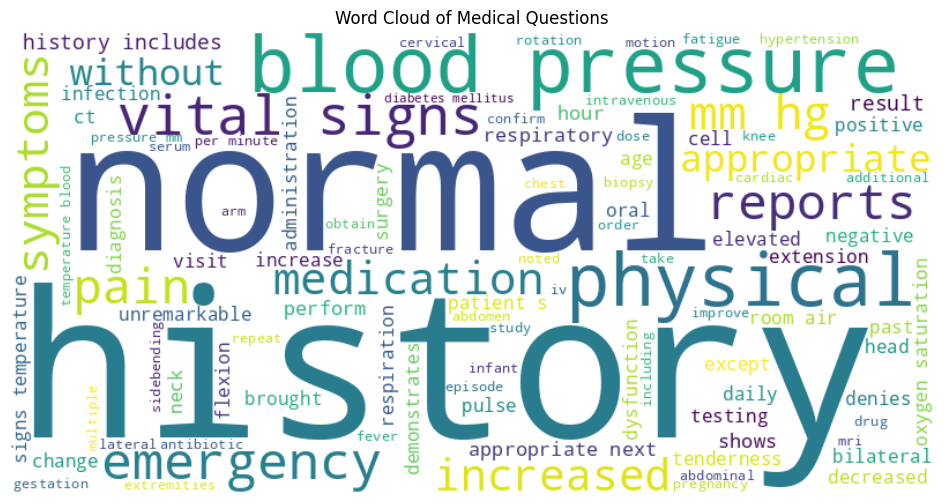

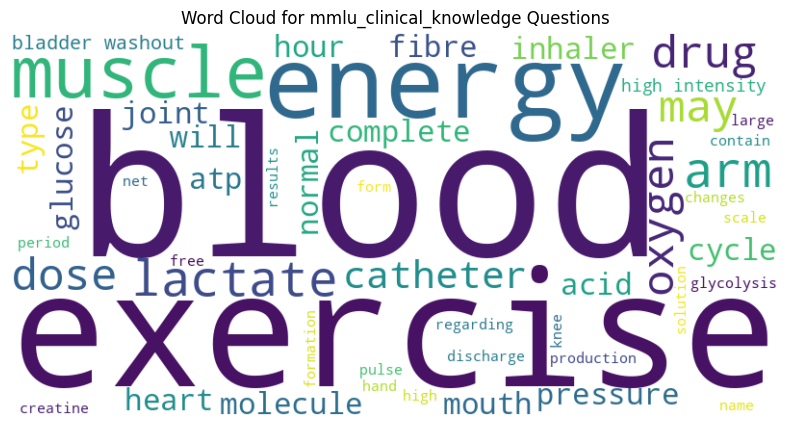

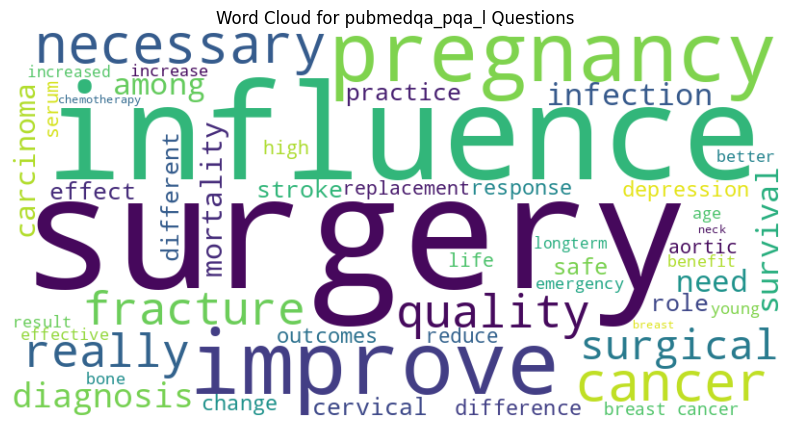

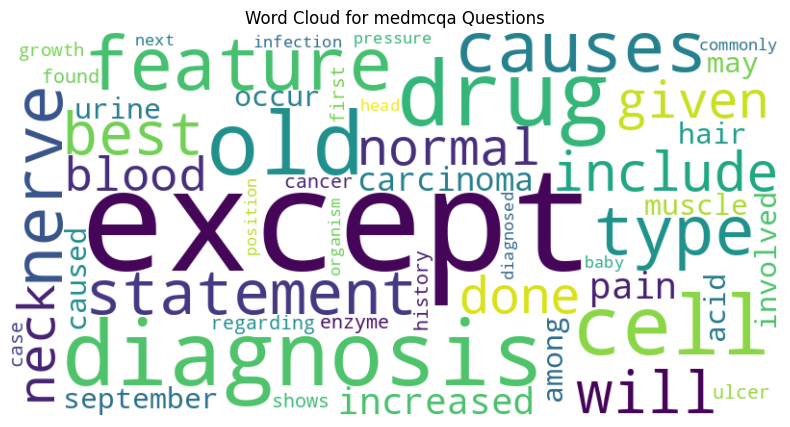

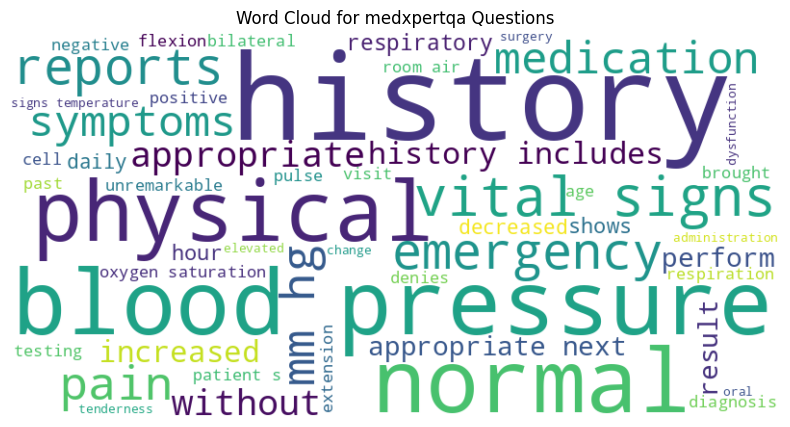

In [6]:
# Step 5: Word cloud visualization for questions (simplified version)
import re
import string
from wordcloud import WordCloud

# Define a simplified stopwords list (common English stopwords)
simple_stopwords =  {
    # Assessment and evaluation terms
    'true', 'false', 'correct', 'incorrect', 'primary', 'secondary', 'tertiary', 
    'predict', 'outcome', 'risk', 'likely', 'probability', 'possible', 'estimate',
    'affect', 'affects', 'affecting', 'associated', 'association', 'correlation',
    'relationship', 'link', 'linked', 'linked to', 'associated with', 'associated to',
    'seen', 'time', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o',
    '°c', '°f', '°k', '°r', '°n', '°s', '°t', '°u', '°v', '°w', '°x', '°y', '°z',
    'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'b1', 'b2', 'b3', 'b4', 'b5',
    'b6', 'b7', 'b8', 'b9', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9',
    'not', 'no', 'none', 'never', 'nothing', 'nobody', 'nowhere', 'neither',
    'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    'min', 'max', 'mean', 'median', 'mode', 'sd', 'se', 'ci', 'iqr',
    '-', '–', 'many', 'person', 'much', 'more', 'less', 'most', 'least','report', 'due',
    'her', 'his', 'its', 'their', 'our', 'my', 'your', 'whose', 'who', 'whom',
    'what', 'where', 'when', 'why', 'how', 'which', 'that', 'whoever', 'whomever',
    'ago', 'before', 'after', 'during', 'until', 'while', 'as', 'like',
    'woman', 'man', 'child', 'adult', 'people', 'individual', 'individuals','women','men'
    'choose', 'department', 'department', 'hospital', 'clinic', 'office', 'unit',
    'physician', 'nurse', 'staff', 'provider', 'patient', 'caregiver', 'family',
    'children', 'adolescents', 'teenagers', 'young adults', 'adults', 'elderly',
    'answer', 'answers', 'question', 'questions', 'choice', 'choices',
    'option', 'options', 'select', 'selecting', 'selected', 'choose', 'choosing',
    'chosen', 'pick', 'picking', 'picked', 'indicate', 'indicating', 'indicated',
    'show', 'showing', 'shown', 'demonstrate', 'demonstrating', 'demonstrated',
    'suggest', 'suggesting', 'suggested', 'recommend', 'recommending', 'recommended',
    'advise', 'advising', 'advised', 'inform', 'informing', 'informed',
    'explain', 'explaining', 'explained', 'describe', 'describing', 'described', 'reveal',
    'reveals', 'disclose', 'day', 'days', 'week', 'weeks', 'month', 'months', 'year', 'years',
    'mother', 'father', 'sister', 'brother', 'son', 'daughter', 'parent', 'guardian',
    'relative', 'friend', 'partner', 'spouse', 'husband', 'wife', 'family member',
    'describe', 'describes', 'describing', 'described', 'indicate', 'indicates',
    'initiate', 'initiates', 'initiating', 'initiated', 'start', 'starts',
    'male', 'female', 'right', 'left', 'upper', 'lower', 'anterior', 'posterior',
    'finding', 'findings', 'finding', 'finding', 'finding', 'finding', 'finding',
    'mmhg', 'mmhg', 'mg', 'ml', 'ml/kg', 'mg/dl', 'ug/ml', 'ng/ml',
    'pg/ml', 'iu/ml', 'mEq/L', 'mEq/kg', 'mEq/dl', 'mEq/L/h', 'mEq/L/min',
    'presents', 'presenting', 'presented', 'presents', 'presenting', 'presented',
    'expect', 'expecting', 'expected', 'expectation', 'expectations',
    
    # Generic health terms
    'health', 'patient', 'patients', 'treatment', 'care', 'management', 'therapy',
    'clinical', 'medical', 'medicine', 'physician', 'doctor', 'healthcare', 'hospital',
    
    # Generic descriptors
    'common', 'rare', 'acute', 'chronic', 'severe', 'mild', 'moderate', 'marked',
    'significant', 'minimal', 'substantial', 'pronounced', 'slight', 'major', 'minor',
    
    # Generic action words
    'present', 'presenting', 'presented', 'manage', 'managing', 'managed', 'treat',
    'treating', 'treated', 'administer', 'administering', 'administered', 'provide',
    'providing', 'provided', 'recommend', 'recommending', 'recommended', 'prescribe',
    'prescribing', 'prescribed', 'evaluate', 'evaluating', 'evaluated', 'yearold',
    
    # Generic condition words
    'condition', 'disease', 'disorder', 'syndrome', 'symptom', 'sign', 'indication',
    'manifestation', 'presentation', 'complication', 'sequela', 'etiology', 'cause',
    'factor', 'association', 'correlation', 'relationship', 'linked', 'associated',
    
    # Generic procedure and test terms
    'procedure', 'test', 'examination', 'scan', 'imaging', 'laboratory', 'diagnostic',
    'assessment', 'evaluation', 'monitoring', 'screening', 'investigation', 'workup',
    
    # Generic measurement terms
    'level', 'levels', 'rate', 'rates', 'count', 'counts', 'value', 'values', 
    'measurement', 'measurements', 'parameter', 'parameters', 'index', 'indices',
    
    # Time and process terms
    'initial', 'initially', 'subsequent', 'subsequently', 'follow', 'following',
    'prior', 'previously', 'current', 'currently', 'recent', 'recently', 'onset',
    'acute', 'chronic', 'immediate', 'delayed', 'early', 'late', 'duration', 'one', 'two', 'three',
    'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'used', 'use', 'step'
}

def simple_clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in simple_stopwords]
    return ' '.join(words)

# Clean the questions
df['clean_question'] = df['question'].apply(simple_clean_text)

# Create a word cloud
all_text = ' '.join(df['clean_question'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Medical Questions')
plt.show()

# Domain-specific word clouds
# We need to modify this section too since we're not using NLTK domains
# Simplified approach without using the domains dictionary
# Instead, let's analyze by dataset source

for dataset_name in df['dataset'].unique():
    dataset_questions = df[df['dataset'] == dataset_name]
    if len(dataset_questions) == 0:
        continue
        
    dataset_text = ' '.join(dataset_questions['clean_question'])
    if dataset_text:
        dataset_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(dataset_text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(dataset_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {dataset_name} Questions')
        plt.show()

Model Accuracy:
Gemini: 35.63%
NVIDIA: 43.08%
Vertex Gemma: 11.20%

Accuracy by Domain:


count    gemini    nvidia  vertex_gemma
otolaryngology      1520.0  0.303289  0.350000      0.081579
radiology           1428.0  0.292717  0.350840      0.093137
infectious_disease  1065.0  0.288263  0.327700      0.060094
hematology           908.0  0.230176  0.253304      0.053965
emergency_medicine   827.0  0.218863  0.250302      0.054414
pharmacology         656.0  0.263720  0.306402      0.048780
rheumatology         641.0  0.248050  0.269891      0.054602
orthopedics          622.0  0.210611  0.249196      0.061093
neurology            595.0  0.235294  0.273950      0.053782
obstetrics           562.0  0.240214  0.261566      0.056940
gastroenterology     536.0  0.231343  0.305970      0.065299
cardiology           512.0  0.216797  0.255859      0.058594
pulmonology          492.0  0.211382  0.262195      0.030488
nephrology           412.0  0.274272  0.271845      0.046117
oncology             392.0  0.242347  0.331633      0.084184
psychiatry           378.0  0.222222  0.253968      0.063492
endocrinology        328.0  0.198171  0.246951      0.057927
pediatrics           327.0  0.314985  0.357798      0.082569
surgery              313.0  0.268371  0.325879      0.076677
dermatology          284.0  0.316901  0.341549      0.056338
urology              199.0  0.236181  0.271357      0.065327
anesthesiology       172.0  0.290698  0.296512      0.069767
ophthalmology        151.0  0.337748  0.337748      0.066225
unclassified          95.0  0.652632  0.705263      0.136842

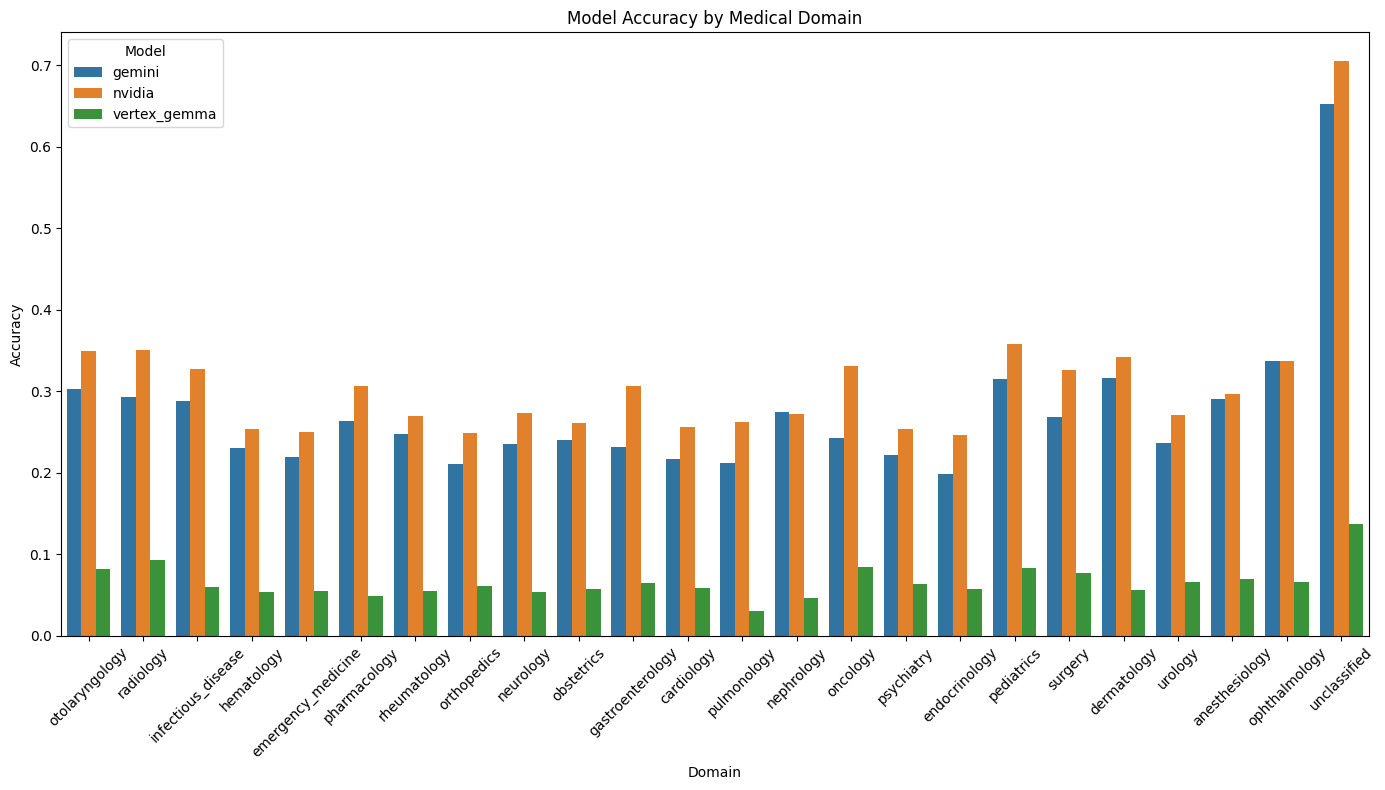

In [7]:
# Step 6: Model performance analysis
# Calculate each model's accuracy
df['gemini_correct'] = (df['gemini_parsed'] == df['ground_truth_answer']).astype(int)
df['nvidia_correct'] = (df['nvidia_parsed'] == df['ground_truth_answer']).astype(int)
df['vertex_gemma_correct'] = (df['vertex_gemma_parsed'] == df['ground_truth_answer']).astype(int)

# Overall accuracy
print("Model Accuracy:")
print(f"Gemini: {df['gemini_correct'].mean():.2%}")
print(f"NVIDIA: {df['nvidia_correct'].mean():.2%}")
print(f"Vertex Gemma: {df['vertex_gemma_correct'].mean():.2%}")

# Accuracy by domain
print("\nAccuracy by Domain:")
domain_list = list(medical_domains.keys()) + ['unclassified']
domain_accuracy = {}

for domain in domain_list:
    domain_questions = df[df['domains'].apply(lambda x: domain in x)]
    if len(domain_questions) == 0:
        continue
    
    domain_accuracy[domain] = {
        'count': len(domain_questions),
        'gemini': domain_questions['gemini_correct'].mean(),
        'nvidia': domain_questions['nvidia_correct'].mean(),
        'vertex_gemma': domain_questions['vertex_gemma_correct'].mean()
    }

domain_acc_df = pd.DataFrame(domain_accuracy).T
domain_acc_df = domain_acc_df.sort_values('count', ascending=False)
display(domain_acc_df)

# Visualize accuracy by domain
plt.figure(figsize=(14, 8))
domain_acc_df = domain_acc_df.reset_index()
domain_acc_df = pd.melt(domain_acc_df, id_vars=['index', 'count'], 
                         value_vars=['gemini', 'nvidia', 'vertex_gemma'],
                         var_name='Model', value_name='Accuracy')

sns.barplot(x='index', y='Accuracy', hue='Model', data=domain_acc_df)
plt.title('Model Accuracy by Medical Domain')
plt.xlabel('Domain')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

Explained variance ratio: 76.27%


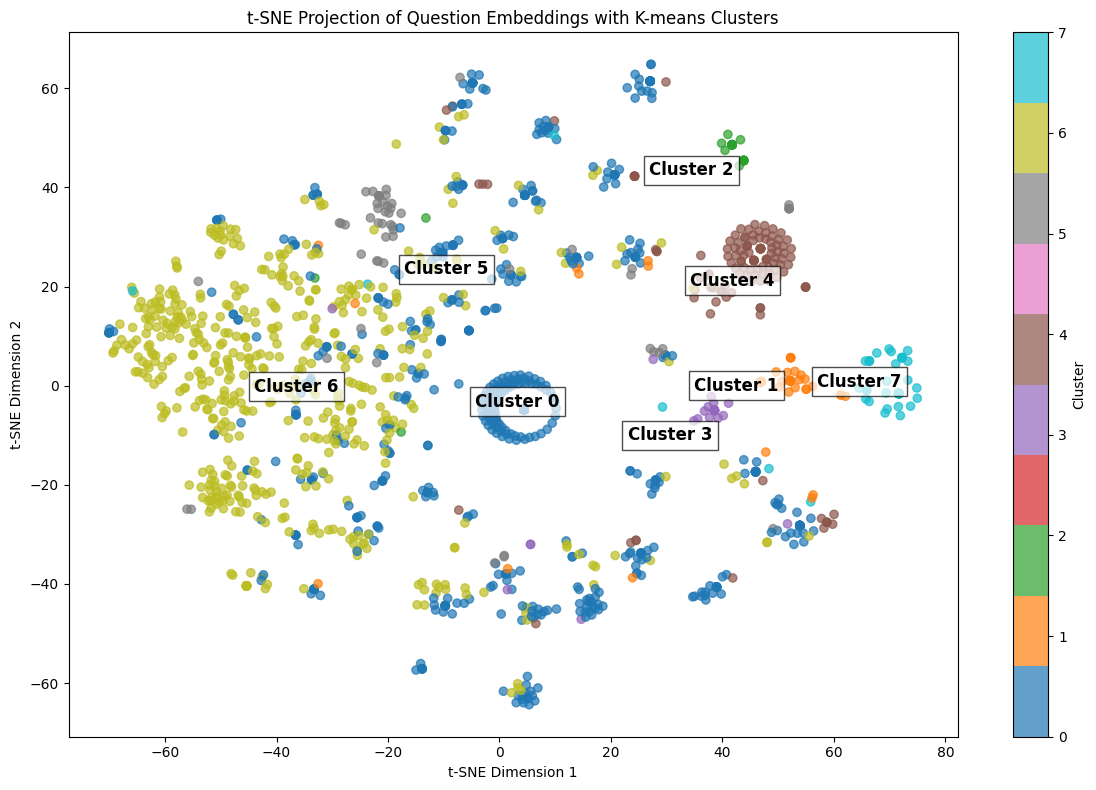

Enhanced interactive visualization saved to 'question_clusters.html'


In [9]:
# Step 7: Text embeddings and clustering with improved hover information
# Create TF-IDF vectors
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['clean_question'])

# Dimensionality reduction for visualization
# Using TruncatedSVD (similar to PCA but works on sparse matrices)
svd = TruncatedSVD(n_components=50)
svd_result = svd.fit_transform(tfidf_matrix)
print(f"Explained variance ratio: {sum(svd.explained_variance_ratio_):.2%}")

# Using t-SNE for 2D visualization (built into sklearn)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding = tsne.fit_transform(svd_result)

# Perform K-means clustering
num_clusters = 8  # Adjust based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(svd_result)
df['cluster'] = clusters

# Save the embedding and clusters for later analysis
df['tsne_x'] = embedding[:, 0]
df['tsne_y'] = embedding[:, 1]

# Create a difficulty score if it doesn't exist (based on num_models_incorrect)
if 'difficulty' not in df.columns and 'num_models_incorrect' in df.columns:
    # Normalize to 0-1 scale
    df['difficulty'] = df['num_models_incorrect'] / 3  # Assuming max is 3 models
elif 'difficulty' not in df.columns:
    # Create a placeholder difficulty column if we can't calculate it
    df['difficulty'] = 0.0

# Visualize the clusters using matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Projection of Question Embeddings with K-means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add cluster labels
for i in range(num_clusters):
    # Find the center of each cluster
    cluster_points = embedding[clusters == i]
    center_x = cluster_points[:, 0].mean()
    center_y = cluster_points[:, 1].mean()
    plt.annotate(f'Cluster {i}', (center_x, center_y), fontsize=12, 
                 fontweight='bold', ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# Create interactive Plotly visualization with question hover text
try:
    import plotly.express as px
    import plotly.graph_objects as go
    
    # Create a DataFrame specifically for the visualization with only existing columns
    viz_df = pd.DataFrame({
        'x': embedding[:, 0],
        'y': embedding[:, 1],
        'cluster': clusters,
        'question': df['question']
    })
    
    # Add optional columns if they exist
    if 'dataset' in df.columns:
        viz_df['dataset'] = df['dataset']
    else:
        viz_df['dataset'] = 'Unknown'
        
    if 'domains' in df.columns:
        viz_df['domain'] = df['domains'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
    else:
        viz_df['domain'] = 'Unknown'
        
    viz_df['difficulty'] = df['difficulty']
    
    if 'ground_truth_answer' in df.columns:
        viz_df['ground_truth'] = df['ground_truth_answer']
    else:
        viz_df['ground_truth'] = 'Unknown'
    
    # Create a more informative hover template
    fig = px.scatter(
        viz_df,
        x='x',
        y='y',
        color='cluster',
        hover_data=['question', 'dataset', 'domain', 'difficulty', 'ground_truth'],
        labels={
            'x': 't-SNE Dimension 1',
            'y': 't-SNE Dimension 2',
            'cluster': 'Cluster'
        },
        title='Interactive Cluster Visualization of Medical Questions (t-SNE)'
    )
    
    # Update hover template to show full question
    fig.update_traces(
        hovertemplate='<b>Question:</b> %{customdata[0]}<br><br>' +
                      '<b>Dataset:</b> %{customdata[1]}<br>' +
                      '<b>Domain:</b> %{customdata[2]}<br>' +
                      '<b>Difficulty:</b> %{customdata[3]:.2f}<br>' +
                      '<b>Correct Answer:</b> %{customdata[4]}<br>' +
                      '<b>Cluster:</b> %{marker.color}'
    )
    
    # Save to HTML file
    fig.write_html('question_clusters.html')
    print("Enhanced interactive visualization saved to 'question_clusters.html'")
    
except ImportError:
    print("Plotly not available. Using only matplotlib visualization.")
    
    # Alternative for matplotlib: Annotate a few example points
    print("Tip: If you want to see questions on the matplotlib plot, you can use annotate for specific points:")
    print("plt.annotate(df['question'].iloc[i][:50] + '...', (embedding[i, 0], embedding[i, 1]))")

In [10]:
from IPython.display import HTML

# For a file in the same directory
with open('question_clusters.html', 'r') as f:
    html_content = f.read()
    
display(HTML(html_content))

In [ ]:
# Step 8: Analyze clusters
# Find the most representative terms for each cluster
def get_cluster_terms(cluster_id, top_n=10):
    cluster_docs = df[df['cluster'] == cluster_id]['clean_question'].tolist()
    if not cluster_docs:
        return []
    
    # Create a new TF-IDF vectorizer for the cluster
    cluster_tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    cluster_matrix = cluster_tfidf.fit_transform(cluster_docs)
    
    # Get feature names and their average TF-IDF scores
    feature_names = cluster_tfidf.get_feature_names_out()
    cluster_scores = cluster_matrix.toarray().mean(axis=0)
    
    # Sort by score and get top terms
    top_indices = cluster_scores.argsort()[-top_n:][::-1]
    return [(feature_names[i], cluster_scores[i]) for i in top_indices]

# Print top terms for each cluster
print("Top terms for each cluster:")
for i in range(num_clusters):
    terms = get_cluster_terms(i)
    print(f"Cluster {i}: {[term for term, _ in terms]}")
    
    # Count domains in this cluster
    cluster_df = df[df['cluster'] == i]
    cluster_domains = []
    for domains in cluster_df['domains']:
        cluster_domains.extend(domains)
    domain_counts = Counter(cluster_domains)
    top_domains = domain_counts.most_common(3)
    print(f"  Top domains: {top_domains}")
    print(f"  Question count: {len(cluster_df)}")
    print()

Top terms for each cluster:
Cluster 0: ['diagnosis', 'pain', 'cell', 'type', 'drug', 'surgical', 'carcinoma', 'high', 'nerve', 'symptoms']
  Top domains: [('otolaryngology', 770), ('radiology', 733), ('infectious_disease', 489)]
  Question count: 1281

Cluster 1: ['cancer', 'breast', 'prostate', 'does', 'lung', 'colorectal', 'survival', 'gastric', 'cervical', 'chemotherapy']
  Top domains: [('oncology', 66), ('otolaryngology', 46), ('radiology', 45)]
  Question count: 66

Cluster 2: ['pregnancy', 'does', 'fetal', 'increase', 'depression', 'history', 'different', 'smoking', 'myomas', 'perforation']
  Top domains: [('obstetrics', 25), ('otolaryngology', 15), ('radiology', 13)]
  Question count: 25

Cluster 3: ['muscle', 'lactate', 'ligament', 'breakdown', 'glycogen', 'function', 'exercise', 'formation', 'diagnosis', 'pain']
  Top domains: [('radiology', 20), ('otolaryngology', 15), ('infectious_disease', 11)]
  Question count: 24

Cluster 4: ['does', 'improve', 'influence', 'quality', 'a